# Rppg 신호측정
1. 웹캠으로 실시간으로  RPPG측정
2. 동영상 불러와서 RPPG측정
3. 동영상에서 이미지 frame 캡처해서 RPPG 측정

In [1]:
import cv2

from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import glob
import natsort
import csv

In [2]:
def create_skin_mask(img):
    mask = None
    # 얼굴영역 검출 (피부픽셀 검출)
    try:
        low = np.array([0, 133, 77], np.uint8)
        high = np.array([235, 173, 127], np.uint8)
        
        # 얼굴 box를 찾은 후에 피부픽셀만 분리하는 함수 (실시간성을 고려하지 않으면 다른 모델로 대체 가능)
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        mask = cv2.inRange(ycrcb, low, high)
        mask[mask == 255] = 1
    except Exception:
        pass

    return mask

def detrend_signal(arr, win_size):
    # 신호 후처리 함수 (detrend = 추세 를 없앤다.)
    #심박과 관련없는 저주파 와 같은 추세를 없애는 것
    try:
        if arr.ndim == 1:
            arr = np.expand_dims(arr, axis=0)
        n_channel = arr.shape[0]
        norm = signal.convolve2d(np.ones_like(arr), np.ones((n_channel, win_size)), mode='same')
        mean = signal.convolve2d(arr, np.ones((n_channel, win_size)), mode='same') / norm
        return (arr - mean) / (mean + 1e-15)
    except ValueError:
        return arr

def filter_bandpass(arr, srate, band):
    #대역통과필터
    try:
        # 심박수(bpm)의 주파수 도메인은 HZ , 따라서 60을 곱해야 초당이 아닌 분당으로 계산
        nyq = 60 * srate / 2
        coef_vector = signal.butter(5, [band[0] / nyq, band[1] / nyq], 'bandpass')
        return signal.filtfilt(*coef_vector, arr)
    except ValueError:
        return arr
    
def estimate_average_pulserate(arr, srate):
    # 후처리가 완료된 데이터로ㅓ 맥박수 측정
    f, pxx = signal.periodogram(arr, fs=srate, window='hann')
    # 가장 쎈 대역? 주파수 를 찾는다. >> 분당으로 환산한것이 pulserate
    max_peak_idx = np.argmax(pxx)
    pulserate = int(f[max_peak_idx] * 60)
    return min(max(pulserate, band[0]), band[1])

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_1_0.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_2_33.333300000056624.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_3_66.66669999994338.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_4_100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_5_133.33330000005662.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_6_166.66669999994338.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_7_200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_8_233.33330000005662.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_9_266.6666999999434.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_10_300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_11_333.3333000000566.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_12_366.6666999999434.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_0_13_400.0.png
img path:  D:\

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_108_3566.6666999999434.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_109_3600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_110_3633.3333000000566.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_111_3666.6666999999434.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_112_3700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_113_3733.3333000000566.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_114_3766.6666999999434.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_115_3800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_116_3833.3333000000566.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_117_3866.6666999999434.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_118_3900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_3_119_3933.3333000000566.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_213_7066.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_214_7100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_215_7133.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_216_7166.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_217_7200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_218_7233.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_219_7266.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_220_7300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_221_7333.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_222_7366.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_223_7400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_224_7433.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_7_225_

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_320_10633.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_321_10666.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_322_10700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_323_10733.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_324_10766.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_325_10800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_326_10833.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_327_10866.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_328_10900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_329_10933.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_10_330_10966.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_11_331_11000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HR

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_425_14133.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_426_14166.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_427_14200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_428_14233.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_429_14266.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_430_14300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_431_14333.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_432_14366.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_433_14400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_434_14433.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_435_14466.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_14_436_14500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HR

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_531_17666.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_532_17700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_533_17733.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_534_17766.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_535_17800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_536_17833.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_537_17866.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_538_17900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_539_17933.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_17_540_17966.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_18_541_18000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_18_542_18033.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HR

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_634_21100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_635_21133.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_636_21166.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_637_21200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_638_21233.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_639_21266.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_640_21300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_641_21333.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_642_21366.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_643_21400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_644_21433.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_21_645_21466.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HR

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_736_24500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_737_24533.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_738_24566.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_739_24600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_740_24633.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_741_24666.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_742_24700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_743_24733.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_744_24766.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_745_24800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_746_24833.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_24_747_24866.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HR

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_842_28033.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_843_28066.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_844_28100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_845_28133.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_846_28166.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_847_28200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_848_28233.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_849_28266.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_850_28300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_851_28333.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_852_28366.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_28_853_28400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HR

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_945_31466.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_946_31500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_947_31533.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_948_31566.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_949_31600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_950_31633.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_951_31666.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_952_31700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_953_31733.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_954_31766.666699999943.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_955_31800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_31_956_31833.333300000057.png
img path:  D:\prlab\ysg\rppg\rppg_HR

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1051_35000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1052_35033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1053_35066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1054_35100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1055_35133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1056_35166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1057_35200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1058_35233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1059_35266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1060_35300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1061_35333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_35_1062_35366.66669999994.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1153_38400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1154_38433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1155_38466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1156_38500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1157_38533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1158_38566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1159_38600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1160_38633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1161_38666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1162_38700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1163_38733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_38_1164_38766.66669999994.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_41_1255_41800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_41_1256_41833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_41_1257_41866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_41_1258_41900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_41_1259_41933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_41_1260_41966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_42_1261_42000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_42_1262_42033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_42_1263_42066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_42_1264_42100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_42_1265_42133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_42_1266_42166.66669999994.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1357_45200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1358_45233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1359_45266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1360_45300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1361_45333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1362_45366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1363_45400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1364_45433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1365_45466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1366_45500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1367_45533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_45_1368_45566.66669999994.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_48_1463_48733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_48_1464_48766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_48_1465_48800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_48_1466_48833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_48_1467_48866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_48_1468_48900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_48_1469_48933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_48_1470_48966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_49_1471_49000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_49_1472_49033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_49_1473_49066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_49_1474_49100.0.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1567_52200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1568_52233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1569_52266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1570_52300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1571_52333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1572_52366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1573_52400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1574_52433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1575_52466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1576_52500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1577_52533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_52_1578_52566.66669999994.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_55_1672_55700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_55_1673_55733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_55_1674_55766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_55_1675_55800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_55_1676_55833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_55_1677_55866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_55_1678_55900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_55_1679_55933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_55_1680_55966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_56_1681_56000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_56_1682_56033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_56_1683_56066.66669999994.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1776_59166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1777_59200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1778_59233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1779_59266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1780_59300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1781_59333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1782_59366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1783_59400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1784_59433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1785_59466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1786_59500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_59_1787_59533.33330000006.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1881_62666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1882_62700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1883_62733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1884_62766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1885_62800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1886_62833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1887_62866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1888_62900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1889_62933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_62_1890_62966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_63_1891_63000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_63_1892_63033.33330000006.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1983_66066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1984_66100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1985_66133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1986_66166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1987_66200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1988_66233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1989_66266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1990_66300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1991_66333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1992_66366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1993_66400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_66_1994_66433.33330000006.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2087_69533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2088_69566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2089_69600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2090_69633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2091_69666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2092_69700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2093_69733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2094_69766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2095_69800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2096_69833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2097_69866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_69_2098_69900.0.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_72_2189_72933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_72_2190_72966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2191_73000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2192_73033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2193_73066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2194_73100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2195_73133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2196_73166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2197_73200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2198_73233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2199_73266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_73_2200_73300.0.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2295_76466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2296_76500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2297_76533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2298_76566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2299_76600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2300_76633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2301_76666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2302_76700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2303_76733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2304_76766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2305_76800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_76_2306_76833.33330000006.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_79_2398_79900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_79_2399_79933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_79_2400_79966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_80_2401_80000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_80_2402_80033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_80_2403_80066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_80_2404_80100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_80_2405_80133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_80_2406_80166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_80_2407_80200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_80_2408_80233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_80_2409_80266.66669999994.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2502_83366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2503_83400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2504_83433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2505_83466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2506_83500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2507_83533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2508_83566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2509_83600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2510_83633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2511_83666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2512_83700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_83_2513_83733.33330000006.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_86_2607_86866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_86_2608_86900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_86_2609_86933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_86_2610_86966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_87_2611_87000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_87_2612_87033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_87_2613_87066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_87_2614_87100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_87_2615_87133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_87_2616_87166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_87_2617_87200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_87_2618_87233.33330000006.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2711_90333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2712_90366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2713_90400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2714_90433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2715_90466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2716_90500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2717_90533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2718_90566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2719_90600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2720_90633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2721_90666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_90_2722_90700.0.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_93_2814_93766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_93_2815_93800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_93_2816_93833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_93_2817_93866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_93_2818_93900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_93_2819_93933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_93_2820_93966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_94_2821_94000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_94_2822_94033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_94_2823_94066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_94_2824_94100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_94_2825_94133.33330000006.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2920_97300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2921_97333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2922_97366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2923_97400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2924_97433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2925_97466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2926_97500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2927_97533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2928_97566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2929_97600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2930_97633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_97_2931_97666.66669999994.png
img path:  D:\prlab\ysg\rppg\rpp

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_100_3022_100700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_100_3023_100733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_100_3024_100766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_100_3025_100800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_100_3026_100833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_100_3027_100866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_100_3028_100900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_100_3029_100933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_100_3030_100966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_101_3031_101000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_101_3032_101033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_101_3033_101066.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3125_104133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3126_104166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3127_104200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3128_104233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3129_104266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3130_104300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3131_104333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3132_104366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3133_104400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3134_104433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3135_104466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_104_3136_104500.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3227_107533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3228_107566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3229_107600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3230_107633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3231_107666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3232_107700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3233_107733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3234_107766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3235_107800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3236_107833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3237_107866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_107_3238_107900.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_110_3330_110966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3331_111000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3332_111033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3333_111066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3334_111100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3335_111133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3336_111166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3337_111200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3338_111233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3339_111266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3340_111300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_111_3341_111333.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3431_114333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3432_114366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3433_114400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3434_114433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3435_114466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3436_114500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3437_114533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3438_114566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3439_114600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3440_114633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3441_114666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_114_3442_114700.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_117_3532_117700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_117_3533_117733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_117_3534_117766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_117_3535_117800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_117_3536_117833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_117_3537_117866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_117_3538_117900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_117_3539_117933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_117_3540_117966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_118_3541_118000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_118_3542_118033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_118_3543_118066.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3634_121100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3635_121133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3636_121166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3637_121200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3638_121233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3639_121266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3640_121300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3641_121333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3642_121366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3643_121400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3644_121433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_121_3645_121466.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3735_124466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3736_124500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3737_124533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3738_124566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3739_124600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3740_124633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3741_124666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3742_124700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3743_124733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3744_124766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3745_124800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_124_3746_124833.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_127_3838_127900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_127_3839_127933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_127_3840_127966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_128_3841_128000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_128_3842_128033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_128_3843_128066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_128_3844_128100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_128_3845_128133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_128_3846_128166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_128_3847_128200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_128_3848_128233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_128_3849_128266.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3939_131266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3940_131300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3941_131333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3942_131366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3943_131400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3944_131433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3945_131466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3946_131500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3947_131533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3948_131566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3949_131600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_131_3950_131633.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_134_4042_134700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_134_4043_134733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_134_4044_134766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_134_4045_134800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_134_4046_134833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_134_4047_134866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_134_4048_134900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_134_4049_134933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_134_4050_134966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_135_4051_135000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_135_4052_135033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_135_4053_135066.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4143_138066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4144_138100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4145_138133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4146_138166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4147_138200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4148_138233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4149_138266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4150_138300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4151_138333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4152_138366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4153_138400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_138_4154_138433.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4244_141433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4245_141466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4246_141500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4247_141533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4248_141566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4249_141600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4250_141633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4251_141666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4252_141700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4253_141733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4254_141766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_141_4255_141800.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_144_4345_144800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_144_4346_144833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_144_4347_144866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_144_4348_144900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_144_4349_144933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_144_4350_144966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_145_4351_145000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_145_4352_145033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_145_4353_145066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_145_4354_145100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_145_4355_145133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_145_4356_145166.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4448_148233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4449_148266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4450_148300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4451_148333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4452_148366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4453_148400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4454_148433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4455_148466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4456_148500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4457_148533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4458_148566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_148_4459_148600.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4548_151566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4549_151600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4550_151633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4551_151666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4552_151700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4553_151733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4554_151766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4555_151800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4556_151833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4557_151866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4558_151900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_151_4559_151933.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4652_155033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4653_155066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4654_155100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4655_155133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4656_155166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4657_155200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4658_155233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4659_155266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4660_155300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4661_155333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4662_155366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_155_4663_155400.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4755_158466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4756_158500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4757_158533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4758_158566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4759_158600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4760_158633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4761_158666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4762_158700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4763_158733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4764_158766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4765_158800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_158_4766_158833.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_161_4855_161800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_161_4856_161833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_161_4857_161866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_161_4858_161900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_161_4859_161933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_161_4860_161966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_162_4861_162000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_162_4862_162033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_162_4863_162066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_162_4864_162100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_162_4865_162133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_162_4866_162166.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4956_165166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4957_165200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4958_165233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4959_165266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4960_165300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4961_165333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4962_165366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4963_165400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4964_165433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4965_165466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4966_165500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_165_4967_165533.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5057_168533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5058_168566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5059_168600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5060_168633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5061_168666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5062_168700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5063_168733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5064_168766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5065_168800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5066_168833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5067_168866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_168_5068_168900.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_171_5158_171900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_171_5159_171933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_171_5160_171966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_172_5161_172000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_172_5162_172033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_172_5163_172066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_172_5164_172100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_172_5165_172133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_172_5166_172166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_172_5167_172200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_172_5168_172233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_172_5169_172266.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5262_175366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5263_175400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5264_175433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5265_175466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5266_175500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5267_175533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5268_175566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5269_175600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5270_175633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5271_175666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5272_175700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_175_5273_175733.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_178_5364_178766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_178_5365_178800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_178_5366_178833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_178_5367_178866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_178_5368_178900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_178_5369_178933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_178_5370_178966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_179_5371_179000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_179_5372_179033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_179_5373_179066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_179_5374_179100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_179_5375_179133.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5468_182233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5469_182266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5470_182300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5471_182333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5472_182366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5473_182400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5474_182433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5475_182466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5476_182500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5477_182533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5478_182566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_182_5479_182600.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5569_185600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5570_185633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5571_185666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5572_185700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5573_185733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5574_185766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5575_185800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5576_185833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5577_185866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5578_185900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5579_185933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_185_5580_185966.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5671_189000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5672_189033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5673_189066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5674_189100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5675_189133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5676_189166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5677_189200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5678_189233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5679_189266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5680_189300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5681_189333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_189_5682_189366.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5776_192500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5777_192533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5778_192566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5779_192600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5780_192633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5781_192666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5782_192700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5783_192733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5784_192766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5785_192800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5786_192833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_192_5787_192866.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_195_5879_195933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_195_5880_195966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5881_196000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5882_196033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5883_196066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5884_196100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5885_196133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5886_196166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5887_196200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5888_196233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5889_196266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_196_5890_196300.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5981_199333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5982_199366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5983_199400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5984_199433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5985_199466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5986_199500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5987_199533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5988_199566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5989_199600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5990_199633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5991_199666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_199_5992_199700.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_202_6082_202700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_202_6083_202733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_202_6084_202766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_202_6085_202800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_202_6086_202833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_202_6087_202866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_202_6088_202900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_202_6089_202933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_202_6090_202966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_203_6091_203000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_203_6092_203033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_203_6093_203066.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6185_206133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6186_206166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6187_206200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6188_206233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6189_206266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6190_206300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6191_206333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6192_206366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6193_206400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6194_206433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6195_206466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_206_6196_206500.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6286_209500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6287_209533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6288_209566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6289_209600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6290_209633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6291_209666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6292_209700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6293_209733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6294_209766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6295_209800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6296_209833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_209_6297_209866.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_212_6389_212933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_212_6390_212966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6391_213000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6392_213033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6393_213066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6394_213100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6395_213133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6396_213166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6397_213200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6398_213233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6399_213266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_213_6400_213300.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6490_216300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6491_216333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6492_216366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6493_216400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6494_216433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6495_216466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6496_216500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6497_216533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6498_216566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6499_216600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6500_216633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_216_6501_216666.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_219_6593_219733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_219_6594_219766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_219_6595_219800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_219_6596_219833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_219_6597_219866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_219_6598_219900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_219_6599_219933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_219_6600_219966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_220_6601_220000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_220_6602_220033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_220_6603_220066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_220_6604_220100.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6696_223166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6697_223200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6698_223233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6699_223266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6700_223300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6701_223333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6702_223366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6703_223400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6704_223433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6705_223466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6706_223500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_223_6707_223533.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6797_226533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6798_226566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6799_226600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6800_226633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6801_226666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6802_226700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6803_226733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6804_226766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6805_226800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6806_226833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6807_226866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_226_6808_226900.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_229_6898_229900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_229_6899_229933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_229_6900_229966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_230_6901_230000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_230_6902_230033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_230_6903_230066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_230_6904_230100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_230_6905_230133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_230_6906_230166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_230_6907_230200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_230_6908_230233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_230_6909_230266.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7000_233300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7001_233333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7002_233366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7003_233400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7004_233433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7005_233466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7006_233500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7007_233533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7008_233566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7009_233600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7010_233633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_233_7011_233666.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_236_7102_236700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_236_7103_236733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_236_7104_236766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_236_7105_236800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_236_7106_236833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_236_7107_236866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_236_7108_236900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_236_7109_236933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_236_7110_236966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_237_7111_237000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_237_7112_237033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_237_7113_237066.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7205_240133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7206_240166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7207_240200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7208_240233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7209_240266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7210_240300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7211_240333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7212_240366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7213_240400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7214_240433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7215_240466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_240_7216_240500.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7308_243566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7309_243600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7310_243633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7311_243666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7312_243700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7313_243733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7314_243766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7315_243800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7316_243833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7317_243866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7318_243900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_243_7319_243933.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_246_7410_246966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7411_247000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7412_247033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7413_247066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7414_247100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7415_247133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7416_247166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7417_247200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7418_247233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7419_247266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7420_247300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_247_7421_247333.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7512_250366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7513_250400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7514_250433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7515_250466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7516_250500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7517_250533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7518_250566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7519_250600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7520_250633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7521_250666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7522_250700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_250_7523_250733.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_253_7616_253833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_253_7617_253866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_253_7618_253900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_253_7619_253933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_253_7620_253966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_254_7621_254000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_254_7622_254033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_254_7623_254066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_254_7624_254100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_254_7625_254133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_254_7626_254166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_254_7627_254200.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7719_257266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7720_257300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7721_257333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7722_257366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7723_257400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7724_257433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7725_257466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7726_257500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7727_257533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7728_257566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7729_257600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_257_7730_257633.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_260_7823_260733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_260_7824_260766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_260_7825_260800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_260_7826_260833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_260_7827_260866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_260_7828_260900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_260_7829_260933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_260_7830_260966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_261_7831_261000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_261_7832_261033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_261_7833_261066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_261_7834_261100.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7927_264200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7928_264233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7929_264266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7930_264300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7931_264333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7932_264366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7933_264400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7934_264433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7935_264466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7936_264500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7937_264533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_264_7938_264566.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8027_267533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8028_267566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8029_267600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8030_267633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8031_267666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8032_267700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8033_267733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8034_267766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8035_267800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8036_267833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8037_267866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_267_8038_267900.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_270_8127_270866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_270_8128_270900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_270_8129_270933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_270_8130_270966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_271_8131_271000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_271_8132_271033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_271_8133_271066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_271_8134_271100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_271_8135_271133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_271_8136_271166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_271_8137_271200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_271_8138_271233.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8227_274200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8228_274233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8229_274266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8230_274300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8231_274333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8232_274366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8233_274400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8234_274433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8235_274466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8236_274500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8237_274533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_274_8238_274566.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8329_277600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8330_277633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8331_277666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8332_277700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8333_277733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8334_277766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8335_277800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8336_277833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8337_277866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8338_277900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8339_277933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_277_8340_277966.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8431_281000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8432_281033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8433_281066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8434_281100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8435_281133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8436_281166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8437_281200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8438_281233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8439_281266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8440_281300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8441_281333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_281_8442_281366.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8535_284466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8536_284500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8537_284533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8538_284566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8539_284600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8540_284633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8541_284666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8542_284700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8543_284733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8544_284766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8545_284800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_284_8546_284833.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_287_8635_287800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_287_8636_287833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_287_8637_287866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_287_8638_287900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_287_8639_287933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_287_8640_287966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_288_8641_288000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_288_8642_288033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_288_8643_288066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_288_8644_288100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_288_8645_288133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_288_8646_288166.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8736_291166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8737_291200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8738_291233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8739_291266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8740_291300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8741_291333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8742_291366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8743_291400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8744_291433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8745_291466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8746_291500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_291_8747_291533.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8837_294533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8838_294566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8839_294600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8840_294633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8841_294666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8842_294700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8843_294733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8844_294766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8845_294800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8846_294833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8847_294866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_294_8848_294900.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_297_8937_297866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_297_8938_297900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_297_8939_297933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_297_8940_297966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_298_8941_298000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_298_8942_298033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_298_8943_298066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_298_8944_298100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_298_8945_298133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_298_8946_298166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_298_8947_298200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_298_8948_298233.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9040_301300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9041_301333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9042_301366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9043_301400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9044_301433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9045_301466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9046_301500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9047_301533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9048_301566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9049_301600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9050_301633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_301_9051_301666.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9141_304666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9142_304700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9143_304733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9144_304766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9145_304800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9146_304833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9147_304866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9148_304900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9149_304933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_304_9150_304966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_305_9151_305000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_305_9152_305033.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9241_308000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9242_308033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9243_308066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9244_308100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9245_308133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9246_308166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9247_308200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9248_308233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9249_308266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9250_308300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9251_308333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_308_9252_308366.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9341_311333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9342_311366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9343_311400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9344_311433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9345_311466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9346_311500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9347_311533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9348_311566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9349_311600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9350_311633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9351_311666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_311_9352_311700.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_314_9443_314733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_314_9444_314766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_314_9445_314800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_314_9446_314833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_314_9447_314866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_314_9448_314900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_314_9449_314933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_314_9450_314966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_315_9451_315000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_315_9452_315033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_315_9453_315066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_315_9454_315100.0.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9544_318100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9545_318133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9546_318166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9547_318200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9548_318233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9549_318266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9550_318300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9551_318333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9552_318366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9553_318400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9554_318433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_318_9555_318466.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9646_321500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9647_321533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9648_321566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9649_321600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9650_321633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9651_321666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9652_321700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9653_321733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9654_321766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9655_321800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9656_321833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_321_9657_321866.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_324_9748_324900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_324_9749_324933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_324_9750_324966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_325_9751_325000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_325_9752_325033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_325_9753_325066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_325_9754_325100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_325_9755_325133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_325_9756_325166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_325_9757_325200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_325_9758_325233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_325_9759_325266.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9849_328266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9850_328300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9851_328333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9852_328366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9853_328400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9854_328433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9855_328466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9856_328500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9857_328533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9858_328566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9859_328600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_328_9860_328633.33330000006.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_331_9952_331700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_331_9953_331733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_331_9954_331766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_331_9955_331800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_331_9956_331833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_331_9957_331866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_331_9958_331900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_331_9959_331933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_331_9960_331966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_332_9961_332000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_332_9962_332033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_332_9963_332066.66669999994.png
img path

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10052_335033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10053_335066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10054_335100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10055_335133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10056_335166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10057_335200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10058_335233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10059_335266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10060_335300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10061_335333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10062_335366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_335_10063_335400.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10151_338333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10152_338366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10153_338400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10154_338433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10155_338466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10156_338500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10157_338533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10158_338566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10159_338600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10160_338633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10161_338666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_338_10162_338700.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10250_341633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10251_341666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10252_341700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10253_341733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10254_341766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10255_341800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10256_341833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10257_341866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10258_341900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10259_341933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_341_10260_341966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_342_10261_342000.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_344_10349_344933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_344_10350_344966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10351_345000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10352_345033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10353_345066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10354_345100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10355_345133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10356_345166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10357_345200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10358_345233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10359_345266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_345_10360_345300.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10450_348300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10451_348333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10452_348366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10453_348400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10454_348433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10455_348466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10456_348500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10457_348533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10458_348566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10459_348600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10460_348633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_348_10461_348666.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10551_351666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10552_351700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10553_351733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10554_351766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10555_351800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10556_351833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10557_351866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10558_351900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10559_351933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_351_10560_351966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_352_10561_352000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_352_10562_352033.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_354_10650_354966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10651_355000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10652_355033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10653_355066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10654_355100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10655_355133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10656_355166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10657_355200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10658_355233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10659_355266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10660_355300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_355_10661_355333.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10751_358333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10752_358366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10753_358400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10754_358433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10755_358466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10756_358500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10757_358533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10758_358566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10759_358600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10760_358633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10761_358666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_358_10762_358700.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10851_361666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10852_361700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10853_361733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10854_361766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10855_361800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10856_361833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10857_361866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10858_361900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10859_361933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_361_10860_361966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_362_10861_362000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_362_10862_362033.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_364_10950_364966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10951_365000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10952_365033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10953_365066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10954_365100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10955_365133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10956_365166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10957_365200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10958_365233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10959_365266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10960_365300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_365_10961_365333.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11050_368300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11051_368333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11052_368366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11053_368400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11054_368433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11055_368466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11056_368500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11057_368533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11058_368566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11059_368600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11060_368633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_368_11061_368666.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_371_11152_371700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_371_11153_371733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_371_11154_371766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_371_11155_371800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_371_11156_371833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_371_11157_371866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_371_11158_371900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_371_11159_371933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_371_11160_371966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_372_11161_372000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_372_11162_372033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_372_11163_372066.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11254_375100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11255_375133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11256_375166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11257_375200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11258_375233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11259_375266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11260_375300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11261_375333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11262_375366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11263_375400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11264_375433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_375_11265_375466.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11355_378466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11356_378500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11357_378533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11358_378566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11359_378600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11360_378633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11361_378666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11362_378700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11363_378733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11364_378766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11365_378800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_378_11366_378833.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_381_11454_381766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_381_11455_381800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_381_11456_381833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_381_11457_381866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_381_11458_381900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_381_11459_381933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_381_11460_381966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_382_11461_382000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_382_11462_382033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_382_11463_382066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_382_11464_382100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_382_11465_382133.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11556_385166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11557_385200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11558_385233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11559_385266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11560_385300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11561_385333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11562_385366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11563_385400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11564_385433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11565_385466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11566_385500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_385_11567_385533.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11657_388533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11658_388566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11659_388600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11660_388633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11661_388666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11662_388700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11663_388733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11664_388766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11665_388800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11666_388833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11667_388866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_388_11668_388900.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_391_11756_391833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_391_11757_391866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_391_11758_391900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_391_11759_391933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_391_11760_391966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_392_11761_392000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_392_11762_392033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_392_11763_392066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_392_11764_392100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_392_11765_392133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_392_11766_392166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_392_11767_392200.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11856_395166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11857_395200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11858_395233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11859_395266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11860_395300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11861_395333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11862_395366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11863_395400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11864_395433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11865_395466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11866_395500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_395_11867_395533.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11955_398466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11956_398500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11957_398533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11958_398566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11959_398600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11960_398633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11961_398666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11962_398700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11963_398733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11964_398766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11965_398800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_398_11966_398833.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_401_12053_401733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_401_12054_401766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_401_12055_401800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_401_12056_401833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_401_12057_401866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_401_12058_401900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_401_12059_401933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_401_12060_401966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_402_12061_402000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_402_12062_402033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_402_12063_402066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_402_12064_402100.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12154_405100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12155_405133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12156_405166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12157_405200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12158_405233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12159_405266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12160_405300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12161_405333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12162_405366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12163_405400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12164_405433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_405_12165_405466.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12253_408400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12254_408433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12255_408466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12256_408500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12257_408533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12258_408566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12259_408600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12260_408633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12261_408666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12262_408700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12263_408733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_408_12264_408766.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_411_12352_411700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_411_12353_411733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_411_12354_411766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_411_12355_411800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_411_12356_411833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_411_12357_411866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_411_12358_411900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_411_12359_411933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_411_12360_411966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_412_12361_412000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_412_12362_412033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_412_12363_412066.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12452_415033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12453_415066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12454_415100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12455_415133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12456_415166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12457_415200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12458_415233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12459_415266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12460_415300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12461_415333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12462_415366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_415_12463_415400.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12553_418400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12554_418433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12555_418466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12556_418500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12557_418533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12558_418566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12559_418600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12560_418633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12561_418666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12562_418700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12563_418733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_418_12564_418766.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_421_12654_421766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_421_12655_421800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_421_12656_421833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_421_12657_421866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_421_12658_421900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_421_12659_421933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_421_12660_421966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_422_12661_422000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_422_12662_422033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_422_12663_422066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_422_12664_422100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_422_12665_422133.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12756_425166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12757_425200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12758_425233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12759_425266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12760_425300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12761_425333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12762_425366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12763_425400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12764_425433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12765_425466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12766_425500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_425_12767_425533.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12854_428433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12855_428466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12856_428500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12857_428533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12858_428566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12859_428600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12860_428633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12861_428666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12862_428700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12863_428733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12864_428766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_428_12865_428800.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_431_12952_431700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_431_12953_431733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_431_12954_431766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_431_12955_431800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_431_12956_431833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_431_12957_431866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_431_12958_431900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_431_12959_431933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_431_12960_431966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_432_12961_432000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_432_12962_432033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_432_12963_432066.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_434_13050_434966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13051_435000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13052_435033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13053_435066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13054_435100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13055_435133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13056_435166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13057_435200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13058_435233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13059_435266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13060_435300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_435_13061_435333.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13150_438300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13151_438333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13152_438366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13153_438400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13154_438433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13155_438466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13156_438500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13157_438533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13158_438566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13159_438600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13160_438633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_438_13161_438666.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13250_441633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13251_441666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13252_441700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13253_441733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13254_441766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13255_441800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13256_441833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13257_441866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13258_441900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13259_441933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_441_13260_441966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_442_13261_442000.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_444_13350_444966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13351_445000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13352_445033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13353_445066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13354_445100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13355_445133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13356_445166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13357_445200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13358_445233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13359_445266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13360_445300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_445_13361_445333.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13449_448266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13450_448300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13451_448333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13452_448366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13453_448400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13454_448433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13455_448466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13456_448500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13457_448533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13458_448566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13459_448600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_448_13460_448633.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13548_451566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13549_451600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13550_451633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13551_451666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13552_451700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13553_451733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13554_451766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13555_451800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13556_451833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13557_451866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13558_451900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_451_13559_451933.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_454_13646_454833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_454_13647_454866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_454_13648_454900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_454_13649_454933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_454_13650_454966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_455_13651_455000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_455_13652_455033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_455_13653_455066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_455_13654_455100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_455_13655_455133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_455_13656_455166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_455_13657_455200.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13745_458133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13746_458166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13747_458200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13748_458233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13749_458266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13750_458300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13751_458333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13752_458366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13753_458400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13754_458433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13755_458466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_458_13756_458500.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13847_461533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13848_461566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13849_461600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13850_461633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13851_461666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13852_461700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13853_461733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13854_461766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13855_461800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13856_461833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13857_461866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_461_13858_461900.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_464_13947_464866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_464_13948_464900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_464_13949_464933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_464_13950_464966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_465_13951_465000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_465_13952_465033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_465_13953_465066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_465_13954_465100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_465_13955_465133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_465_13956_465166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_465_13957_465200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_465_13958_465233.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14045_468133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14046_468166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14047_468200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14048_468233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14049_468266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14050_468300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14051_468333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14052_468366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14053_468400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14054_468433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14055_468466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_468_14056_468500.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14146_471500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14147_471533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14148_471566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14149_471600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14150_471633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14151_471666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14152_471700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14153_471733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14154_471766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14155_471800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14156_471833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_471_14157_471866.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_474_14244_474766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_474_14245_474800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_474_14246_474833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_474_14247_474866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_474_14248_474900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_474_14249_474933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_474_14250_474966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_475_14251_475000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_475_14252_475033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_475_14253_475066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_475_14254_475100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_475_14255_475133.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14343_478066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14344_478100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14345_478133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14346_478166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14347_478200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14348_478233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14349_478266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14350_478300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14351_478333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14352_478366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14353_478400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_478_14354_478433.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14441_481333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14442_481366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14443_481400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14444_481433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14445_481466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14446_481500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14447_481533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14448_481566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14449_481600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14450_481633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14451_481666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_481_14452_481700.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_484_14543_484733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_484_14544_484766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_484_14545_484800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_484_14546_484833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_484_14547_484866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_484_14548_484900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_484_14549_484933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_484_14550_484966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_485_14551_485000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_485_14552_485033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_485_14553_485066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_485_14554_485100.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14645_488133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14646_488166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14647_488200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14648_488233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14649_488266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14650_488300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14651_488333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14652_488366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14653_488400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14654_488433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14655_488466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_488_14656_488500.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14747_491533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14748_491566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14749_491600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14750_491633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14751_491666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14752_491700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14753_491733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14754_491766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14755_491800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14756_491833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14757_491866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_491_14758_491900.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_494_14848_494900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_494_14849_494933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_494_14850_494966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_495_14851_495000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_495_14852_495033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_495_14853_495066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_495_14854_495100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_495_14855_495133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_495_14856_495166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_495_14857_495200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_495_14858_495233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_495_14859_495266.66669999994.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14948_498233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14949_498266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14950_498300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14951_498333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14952_498366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14953_498400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14954_498433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14955_498466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14956_498500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14957_498533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14958_498566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_498_14959_498600.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15047_501533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15048_501566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15049_501600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15050_501633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15051_501666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15052_501700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15053_501733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15054_501766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15055_501800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15056_501833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15057_501866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_501_15058_501900.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_504_15147_504866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_504_15148_504900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_504_15149_504933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_504_15150_504966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_505_15151_505000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_505_15152_505033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_505_15153_505066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_505_15154_505100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_505_15155_505133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_505_15156_505166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_505_15157_505200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_505_15158_505233.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15248_508233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15249_508266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15250_508300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15251_508333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15252_508366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15253_508400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15254_508433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15255_508466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15256_508500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15257_508533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15258_508566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_508_15259_508600.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15348_511566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15349_511600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15350_511633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15351_511666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15352_511700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15353_511733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15354_511766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15355_511800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15356_511833.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15357_511866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15358_511900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_511_15359_511933.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_514_15447_514866.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_514_15448_514900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_514_15449_514933.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_514_15450_514966.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_515_15451_515000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_515_15452_515033.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_515_15453_515066.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_515_15454_515100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_515_15455_515133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_515_15456_515166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_515_15457_515200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_515_15458_515233.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15545_518133.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15546_518166.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15547_518200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15548_518233.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15549_518266.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15550_518300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15551_518333.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15552_518366.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15553_518400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15554_518433.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15555_518466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_518_15556_518500.0.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15645_521466.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15646_521500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15647_521533.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15648_521566.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15649_521600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15650_521633.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15651_521666.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15652_521700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15653_521733.33330000006.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15654_521766.66669999994.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15655_521800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_521_15656_521833.33330000006.

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_524_15747_524866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_524_15748_524900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_524_15749_524933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_524_15750_524966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_525_15751_525000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_525_15752_525033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_525_15753_525066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_525_15754_525100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_525_15755_525133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_525_15756_525166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_525_15757_525200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_525_15758_525233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15852_528366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15853_528400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15854_528433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15855_528466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15856_528500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15857_528533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15858_528566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15859_528600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15860_528633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15861_528666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15862_528700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_528_15863_528733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_531_15957_531866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_531_15958_531900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_531_15959_531933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_531_15960_531966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_532_15961_532000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_532_15962_532033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_532_15963_532066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_532_15964_532100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_532_15965_532133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_532_15966_532166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_532_15967_532200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_532_15968_532233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16062_535366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16063_535400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16064_535433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16065_535466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16066_535500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16067_535533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16068_535566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16069_535600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16070_535633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16071_535666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16072_535700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_535_16073_535733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_538_16170_538966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16171_539000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16172_539033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16173_539066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16174_539100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16175_539133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16176_539166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16177_539200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16178_539233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16179_539266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16180_539300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_539_16181_539333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16278_542566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16279_542600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16280_542633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16281_542666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16282_542700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16283_542733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16284_542766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16285_542800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16286_542833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16287_542866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16288_542900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_542_16289_542933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16382_546033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16383_546066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16384_546100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16385_546133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16386_546166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16387_546200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16388_546233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16389_546266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16390_546300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16391_546333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16392_546366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_546_16393_546400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16488_549566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16489_549600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16490_549633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16491_549666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16492_549700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16493_549733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16494_549766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16495_549800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16496_549833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16497_549866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16498_549900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_549_16499_549933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16592_553033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16593_553066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16594_553100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16595_553133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16596_553166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16597_553200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16598_553233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16599_553266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16600_553300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16601_553333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16602_553366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_553_16603_553400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16696_556500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16697_556533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16698_556566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16699_556600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16700_556633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16701_556666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16702_556700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16703_556733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16704_556766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16705_556800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16706_556833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_556_16707_556866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16804_560100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16805_560133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16806_560166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16807_560200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16808_560233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16809_560266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16810_560300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16811_560333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16812_560366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16813_560400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16814_560433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_560_16815_560466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16911_563666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16912_563700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16913_563733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16914_563766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16915_563800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16916_563833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16917_563866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16918_563900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16919_563933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_563_16920_563966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_564_16921_564000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_564_16922_564033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17017_567200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17018_567233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17019_567266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17020_567300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17021_567333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17022_567366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17023_567400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17024_567433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17025_567466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17026_567500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17027_567533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_567_17028_567566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17121_570666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17122_570700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17123_570733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17124_570766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17125_570800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17126_570833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17127_570866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17128_570900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17129_570933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_570_17130_570966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_571_17131_571000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_571_17132_571033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17228_574233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17229_574266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17230_574300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17231_574333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17232_574366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17233_574400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17234_574433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17235_574466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17236_574500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17237_574533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17238_574566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_574_17239_574600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_577_17333_577733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_577_17334_577766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_577_17335_577800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_577_17336_577833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_577_17337_577866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_577_17338_577900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_577_17339_577933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_577_17340_577966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_578_17341_578000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_578_17342_578033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_578_17343_578066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_578_17344_578100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17438_581233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17439_581266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17440_581300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17441_581333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17442_581366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17443_581400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17444_581433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17445_581466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17446_581500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17447_581533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17448_581566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_581_17449_581600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_584_17544_584766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_584_17545_584800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_584_17546_584833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_584_17547_584866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_584_17548_584900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_584_17549_584933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_584_17550_584966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_585_17551_585000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_585_17552_585033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_585_17553_585066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_585_17554_585100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_585_17555_585133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17650_588300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17651_588333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17652_588366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17653_588400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17654_588433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17655_588466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17656_588500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17657_588533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17658_588566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17659_588600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17660_588633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_588_17661_588666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_591_17754_591766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_591_17755_591800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_591_17756_591833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_591_17757_591866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_591_17758_591900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_591_17759_591933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_591_17760_591966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_592_17761_592000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_592_17762_592033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_592_17763_592066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_592_17764_592100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_592_17765_592133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17860_595300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17861_595333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17862_595366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17863_595400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17864_595433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17865_595466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17866_595500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17867_595533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17868_595566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17869_595600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17870_595633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_595_17871_595666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_598_17967_598866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_598_17968_598900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_598_17969_598933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_598_17970_598966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_599_17971_599000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_599_17972_599033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_599_17973_599066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_599_17974_599100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_599_17975_599133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_599_17976_599166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_599_17977_599200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_599_17978_599233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18074_602433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18075_602466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18076_602500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18077_602533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18078_602566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18079_602600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18080_602633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18081_602666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18082_602700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18083_602733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18084_602766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_602_18085_602800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18182_606033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18183_606066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18184_606100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18185_606133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18186_606166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18187_606200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18188_606233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18189_606266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18190_606300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18191_606333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18192_606366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_606_18193_606400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18289_609600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18290_609633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18291_609666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18292_609700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18293_609733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18294_609766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18295_609800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18296_609833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18297_609866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18298_609900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18299_609933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_609_18300_609966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18396_613166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18397_613200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18398_613233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18399_613266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18400_613300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18401_613333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18402_613366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18403_613400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18404_613433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18405_613466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18406_613500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_613_18407_613533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_616_18503_616733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_616_18504_616766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_616_18505_616800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_616_18506_616833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_616_18507_616866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_616_18508_616900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_616_18509_616933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_616_18510_616966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_617_18511_617000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_617_18512_617033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_617_18513_617066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_617_18514_617100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18611_620333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18612_620366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18613_620400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18614_620433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18615_620466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18616_620500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18617_620533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18618_620566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18619_620600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18620_620633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18621_620666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_620_18622_620700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_623_18715_623800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_623_18716_623833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_623_18717_623866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_623_18718_623900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_623_18719_623933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_623_18720_623966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_624_18721_624000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_624_18722_624033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_624_18723_624066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_624_18724_624100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_624_18725_624133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_624_18726_624166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18821_627333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18822_627366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18823_627400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18824_627433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18825_627466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18826_627500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18827_627533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18828_627566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18829_627600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18830_627633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18831_627666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_627_18832_627700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_630_18927_630866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_630_18928_630900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_630_18929_630933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_630_18930_630966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_631_18931_631000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_631_18932_631033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_631_18933_631066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_631_18934_631100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_631_18935_631133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_631_18936_631166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_631_18937_631200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_631_18938_631233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19032_634366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19033_634400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19034_634433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19035_634466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19036_634500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19037_634533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19038_634566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19039_634600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19040_634633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19041_634666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19042_634700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_634_19043_634733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_637_19139_637933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_637_19140_637966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19141_638000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19142_638033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19143_638066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19144_638100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19145_638133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19146_638166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19147_638200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19148_638233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19149_638266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_638_19150_638300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19245_641466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19246_641500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19247_641533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19248_641566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19249_641600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19250_641633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19251_641666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19252_641700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19253_641733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19254_641766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19255_641800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_641_19256_641833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19352_645033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19353_645066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19354_645100.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19355_645133.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19356_645166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19357_645200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19358_645233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19359_645266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19360_645300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19361_645333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19362_645366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_645_19363_645400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19459_648600.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19460_648633.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19461_648666.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19462_648700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19463_648733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19464_648766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19465_648800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19466_648833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19467_648866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19468_648900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19469_648933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_648_19470_648966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19566_652166.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19567_652200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19568_652233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19569_652266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19570_652300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19571_652333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19572_652366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19573_652400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19574_652433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19575_652466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19576_652500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_652_19577_652533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_655_19672_655700.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_655_19673_655733.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_655_19674_655766.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_655_19675_655800.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_655_19676_655833.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_655_19677_655866.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_655_19678_655900.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_655_19679_655933.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_655_19680_655966.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_656_19681_656000.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_656_19682_656033.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_656_19683_656066.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19777_659200.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19778_659233.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19779_659266.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19780_659300.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19781_659333.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19782_659366.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19783_659400.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19784_659433.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19785_659466.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19786_659500.0.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19787_659533.3333.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\group_659_19788_659566.6667.png
img path:  D:\prlab\ysg\rppg\rppg_HRV\images\11\grou

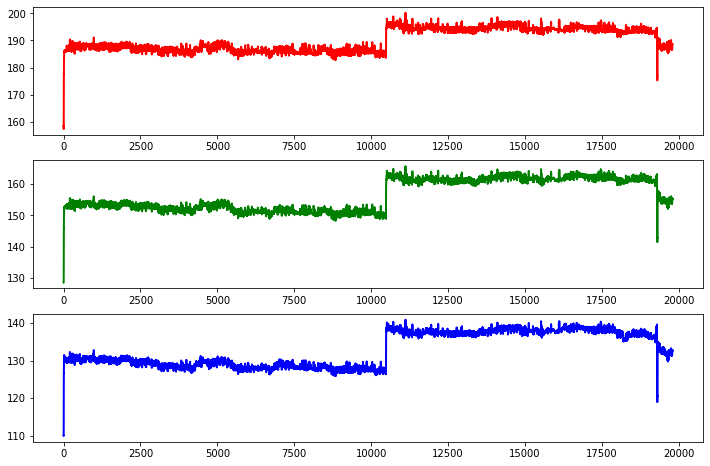

In [3]:
band = [42, 240]
fps = 30

r_signal = []
g_signal = []
b_signal = []
prev_bbox = [0,0,10,10]
curr_bbox = [0,0,10,10]
track_toler = 1
detect_th=0.5
# 얼굴검출 opencv 사용 
detector = cv2.dnn.readNetFromTensorflow('model/face_detector.pb',
                                         'model/face_detector.pbtxt')

times=[]
group=[]
#cap = cv2.VideoCapture(1) # 0: 내장캠 1: 외부캠
#time.sleep(2)

subject=11
file_path="D:\\prlab\\ysg\\rppg\\rppg_HRV\\images\\"+str(subject)
file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

try:
    for file in file_list:
        # group 설정
        g=file.split('\\')[-1].split('_')[1]
        group.append(g)
        # time 설정
        t=file.split('\\')[-1].split('_')[-1][:-4]
        times.append(t)
        # 프레임(img) 가져오기
        print("img path: ",file)
        frame = cv2.imread(file, cv2.IMREAD_COLOR)

        # 현재 프레임에서 얼굴 검출하기
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), [104., 117., 123.], False, False)
        detector.setInput(blob)
        detections = detector.forward()

        h, w = frame.shape[:2]
        bboxes = [detections[0, 0, i, 3:7] for i in range(detections.shape[2]) if detections[0, 0, i, 2] >= detect_th]
        if len(bboxes) > 0:
            bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
            bboxes = [(rect * np.array([w, h, w, h])).astype('int') for rect in bboxes]  # (xs,ys,xe,ye)
            curr_bbox = bboxes[0]
            prev_bbox = curr_bbox
        else:
            curr_bbox = prev_box

        # 얼굴 영역만 잘라내기
        face = frame[curr_bbox[1]:curr_bbox[3], curr_bbox[0]:curr_bbox[2]]

        # remote-PPG 신호 추출하기
        b, g, r = cv2.split(face)
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        # 각신호를 담을 list
        r_signal.append(r_mean)
        g_signal.append(g_mean)
        b_signal.append(b_mean)

        # 얼굴 검출 시각화하기
        cv2.rectangle(frame, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), (0,0,255), 2)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) == 27:
            break
            
    
finally:
    cv2.destroyAllWindows()
    print("==================================================!!!finish!!!=================================================")

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(r_signal, 'r', linewidth=2)
plt.subplot(3,1,2)
plt.plot(g_signal, 'g', linewidth=2)
plt.subplot(3,1,3)
plt.plot(b_signal, 'b', linewidth=2)
plt.show()

In [4]:
len(times)

19801

pulse length:  (19801,)


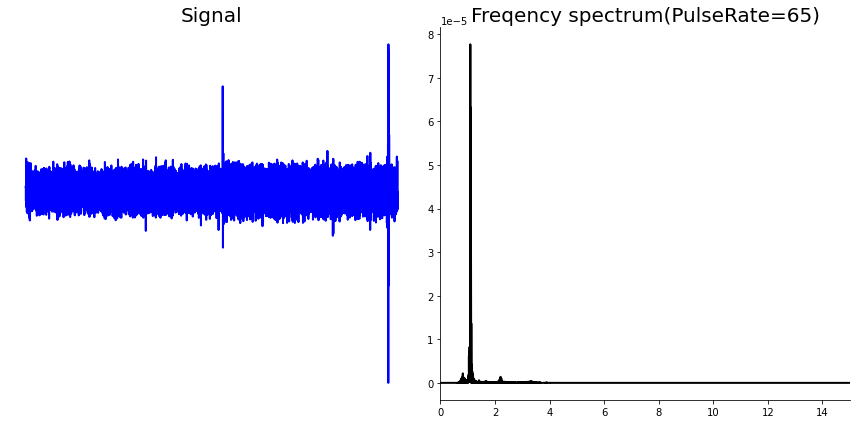

In [5]:
# CHROM 신호 추출
# chrom이란 움직임에 더 강인하게 하는것.
# 움직임은 r,g,b동일하게발생/ pulse는 r,g,b각각 다름
# 이를 이용해 움직임은 제거하고 pulse만 남기도록.

#보통 신호는 g,r,b순으로 잘보인다. 
# 심박수를 더 잘보이게 하기위한 후처리
raw_signal = np.array([r_signal, g_signal, b_signal]).transpose() # 1.세개의 신호를 하나로, 하나의신호화
detrended = detrend_signal(raw_signal, fps) # 2.추세제거
detrended = detrended.transpose()
# 3. 2차원으로 prediction  , 수식에 대해서는 자세히 이해 x
X = 3 * detrended[0] - 2 * detrended[1] # 4. detrend [] > 0: r, 1: g, 2: b
Y = 1.5 * detrended[0] + detrended[1] - 1.5 * detrended[2]
# 5. bandpass filtering
Xf = filter_bandpass(X, fps, band)
Yf = filter_bandpass(Y, fps, band)
alpha = np.std(Xf) / np.std(Yf)
# 6. pulse 신호로 계산
pulse = Xf - alpha * Yf
print("pulse length: ",pulse.shape)

# 심박수 (심장) / '맥박수' (혈관) >> 우리는 맥박수를 보는것.
# 맥박수 계산하는 방법
# 1) 시계열 도메인에서 PPI(peak-to-peak interval) 계산  ==> instant pulse-rate
# 2) 주파수 도메인에서 maximum power band 검출 ==> average pulse-rate


# 주파수 스펙트럼 계산
# 실시간에서는 실시간 fs를 계산해서 파라미터로 넣어줘야함
f, psd = signal.periodogram(pulse, fs=30, window='hann')
max_band = np.argmax(psd)
pr = int(f[max_band] * 60) #분당맥박수
pr = min(max(pr, band[0]), band[1])


plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(pulse, 'b', linewidth=2)    
plt.axis('off')
plt.title('Signal', fontsize=20)

ax = plt.subplot(1,2,2)
plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Freqency spectrum(PulseRate={})'.format(pr), fontsize=20)

plt.tight_layout()
plt.show()

file_num=subject
save_path='D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\'
f = open(save_path+'rppg'+str(file_num)+'.csv', 'w', newline='')
wr = csv.writer(f)
wr.writerow(pulse)
wr.writerow(times)
wr.writerow(group)
f.close()

# RPPG grouping check

In [ ]:
path="D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\rppg11.csv"

In [ ]:
pd.set_option('display.max_rows',None)
data=pd.read_csv(path,header=None)
print(data.columns)
#df=df.transpose()
data=data.transpose()
data.columns=['hr','time','group']
data

In [ ]:
# group 1 > 1초 동안의 frame group
pd.set_option('display.max_rows',None)
groups=data.groupby(data['group'])
print(len(groups))
groups.size()

In [ ]:
# 자세히 확인
i=0
counts=[]
for key,group in groups:
    print("* key",key)
    print("* count",len(group))
    group['sr']=len(group)
    print(group[:])
    counts.append(len(group))
    g=group[:].transpose()
    #g.to_csv("D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\ppg_data\\rppg(var_sr)\\before\\2\\rppg2_"+str(i)+".csv",header=False,index=False)
    i=i+1